In [1]:
!nvidia-smi

Mon Nov  4 16:17:30 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    40W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from radam import RAdam

In [4]:
import os
import gc
import pydicom
import numpy as np 
import pandas as pd
from PIL import Image
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.utils.data as D
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import models, transforms as T
import torch.nn.functional as F

import cv2
import fastai
from fastai.vision import *
from fastai.callbacks.tracker import SaveModelCallback

from albumentations import (
    Compose, RandomRotate90, HorizontalFlip, VerticalFlip, Rotate, ShiftScaleRotate, Transpose,
    Normalize, RandomScale, CenterCrop, RandomGamma, GridDistortion,
    IAAPerspective, JpegCompression, ToGray, ChannelShuffle, RGBShift, CLAHE,
    RandomBrightnessContrast, RandomSunFlare, Cutout, OneOf, Resize
)
from albumentations.pytorch import ToTensor

import pretrainedmodels
print(pretrainedmodels.model_names)

import warnings
warnings.filterwarnings('ignore')

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


## Config

In [5]:
config = {
    'SEED': 242,
    'CLASSES': 6,
    'CHANNELS': 3,
    'PATH_DATA': 'data/',
    'PATH_WEIGHTS': '/home/jupyter/Nikita/',
    'DEVICE': 'cuda',
    'BATCH_SIZE': 32,
    'IMG_SIZE': 410,
    'NUM_WORKERS_ON_MACHINE': 8,
    'VAL_SIZE': 0.20,
    'MODEL_NAME': 'ResNext101_32x4d-RAdam-fp16',
    'USE_BN': False,
    'TrainTA': True,
    'TestTA': True,
    'LR': 1e-4,
    'LR_STR': '1e-4',
    'TURN_OFF_ON_N_EPOCHS': 0,
}

In [6]:
def seed_torch(seed=42):
    import random; import os
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.cuda.empty_cache()
    
seed_torch(config['SEED'])

## Data

In [7]:
df = pd.read_csv(config['PATH_DATA']+'stage_1_train.csv')
train_features = pd.read_feather(config['PATH_DATA'] + 'df_trn.fth').dropna(subset=['img_pct_window'])
train_labels = pd.read_feather(config['PATH_DATA'] + 'labels.fth')

print(df.shape)
print(df['Label'].value_counts(normalize=True))

(4045572, 2)
0    0.942947
1    0.057053
Name: Label, dtype: float64


In [8]:
comb = train_features.join(train_labels.set_index('ID'), 'SOPInstanceUID')
print(comb.shape)

comb = comb.assign(pct_cut = pd.cut(comb.img_pct_window, [0,0.02,0.05,0.1,0.2,0.3,1]))
comb.drop(comb.query('img_pct_window<0.02').index, inplace=True)
print(comb.shape)

(674257, 48)
(595594, 49)


In [9]:
comb.head(2)

,SOPInstanceUID,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,...,WindowCenter1,MultiWindowWidth,WindowWidth1,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,pct_cut
0,ID_231d901c1,CT,ID_b81a287f,ID_dd37ba3adb,ID_15dcd6057a,,-125.0,1.0,1,MONOCHROME2,...,NaN,NaN,NaN,1,0,0,0,1,0,"(0.1, 0.2]"
1,ID_994bc0470,CT,ID_400facde,ID_c5277f0c63,ID_4ba12c2161,,-125.0,1.0,1,MONOCHROME2,...,47.0,1.0,80.0,0,0,0,0,0,0,"(0.1, 0.2]"


In [10]:
newtable = df.copy()
new = newtable["ID"].str.split("_", n = 1, expand = True)
newX = new[1].str.split("_", n = 1, expand = True)
newtable['Image_ID'] = newX[0]
newtable['Sub_type'] = newX[1]

image_ids = newtable.Image_ID.unique()
train_df = pd.DataFrame(np.array([image_ids, np.zeros(len(image_ids))]).transpose(), columns=["id", "labels"])
labels = {i : "" for i in image_ids}

newtable = newtable[newtable.Label == 1]
for name, group in newtable.groupby("Image_ID"):
    labels[name] = " ".join(group.Sub_type)
    
train_df = pd.DataFrame(np.array([list(labels.keys()), list(labels.values())]).transpose(), columns=["id", "labels"])
train_df.id = "ID_" + train_df.id 

train_df = train_df.merge(comb, left_on='id', right_on='SOPInstanceUID', how='right')
train_df.id += ".dcm"

# train_df['labels'].hist(bins=len(train_df.labels.unique()), figsize=[12,6], xrot=90)
print(train_df.shape)
print(train_df['labels'].value_counts(normalize=True))

del new, newX, newtable, labels, df, train_features, train_labels, comb
gc.collect();

(595594, 51)
                                                                        0.837069
subdural any                                                            0.048459
subarachnoid any                                                        0.024698
intraparenchymal any                                                    0.023380
intraventricular any                                                    0.014967
intraparenchymal intraventricular any                                   0.010628
subarachnoid subdural any                                               0.007812
intraparenchymal subarachnoid any                                       0.006063
intraventricular subarachnoid any                                       0.005416
intraparenchymal subdural any                                           0.004956
intraparenchymal subarachnoid subdural any                              0.003387
intraparenchymal intraventricular subarachnoid any                      0.002957
epidural any   

In [11]:
broken_images = ['ID_6431af929.dcm']
broken_indexes = [train_df[train_df.id == i].index for i in broken_images]
train_df.drop(train_df.index[broken_indexes], inplace=True)

In [12]:
train_df.head(2)

,id,labels,SOPInstanceUID,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,...,WindowCenter1,MultiWindowWidth,WindowWidth1,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,pct_cut
0,ID_63eb1e259.dcm,,ID_63eb1e259,CT,ID_a449357f,ID_62d125e5b2,ID_0be5c0d1b3,,-125.0,1.0,...,36.0,1.0,80.0,0,0,0,0,0,0,"(0.2, 0.3]"
1,ID_2669954a7.dcm,,ID_2669954a7,CT,ID_363d5865,ID_a20b80c7bf,ID_3564d584db,,-156.0,1.0,...,47.0,1.0,80.0,0,0,0,0,0,0,"(0.1, 0.2]"


In [13]:
group_splitter = GroupShuffleSplit(test_size=config['VAL_SIZE'], n_splits=2, random_state=config['SEED'])
train_inds, val_inds = next(group_splitter.split(train_df, groups=train_df['PatientID']))  # StudyInstanceUID
train_subset, val_subset = train_df.iloc[train_inds], train_df.iloc[val_inds]

train_subset['is_valid'] = False
val_subset['is_valid'] = True
train_df = train_subset.append(val_subset)
train_df = train_df[['id', 'labels', 'is_valid']]

## Preprocessing

In [14]:
# https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing

def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(img, window_center, window_width, intercept, slope):
    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    return (img - img_min) / (img_max - img_min)

def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

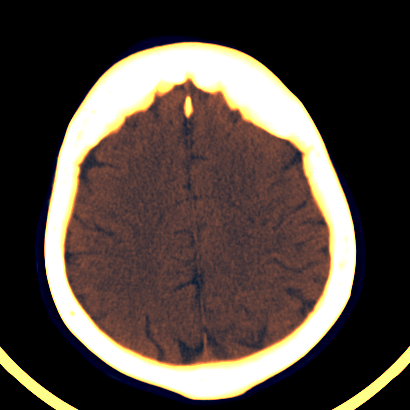

In [15]:
all_transforms = Compose([
    Resize(512, 512),
    CenterCrop(config['IMG_SIZE'], config['IMG_SIZE']),
    HorizontalFlip(),
    VerticalFlip(),
    RandomRotate90(),
    #ShiftScaleRotate(scale_limit=0.1, rotate_limit=45),
    #GridDistortion(num_steps=5, distort_limit=[-0.3,0.3], interpolation=1, border_mode=4),
    #RandomGamma(gamma_limit=[80,120]),
    # ToTensor()
])

# https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/discussion/110728#latest-642755
def new_open_image(path, div=True, convert_mode=None, after_open=None):
    dcm = pydicom.dcmread(str(path))
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    intercept, slope = get_windowing(dcm)
    pixel_array = dcm.pixel_array.astype(np.int16)
    im_1 = window_image(pixel_array, 40, 80, intercept, slope) # brain
    im_2 = window_image(pixel_array, 80, 200, intercept, slope) # subdural
    im_3 = window_image(pixel_array, 300, 1000, intercept, slope) # bone
    im = np.stack((im_1, im_2, im_3), axis=-1)
    
    if config['TrainTA']:
        transformed_im = all_transforms(image=im)['image']
        x = pil2tensor(transformed_im, dtype=np.float32)
    else:
        x = pil2tensor(im, dtype=np.float32)
        
    return Image(x)

vision.data.open_image = new_open_image
tmp = new_open_image('data/stage_1_train_images/ID_63eb1e259.dcm')
tmp

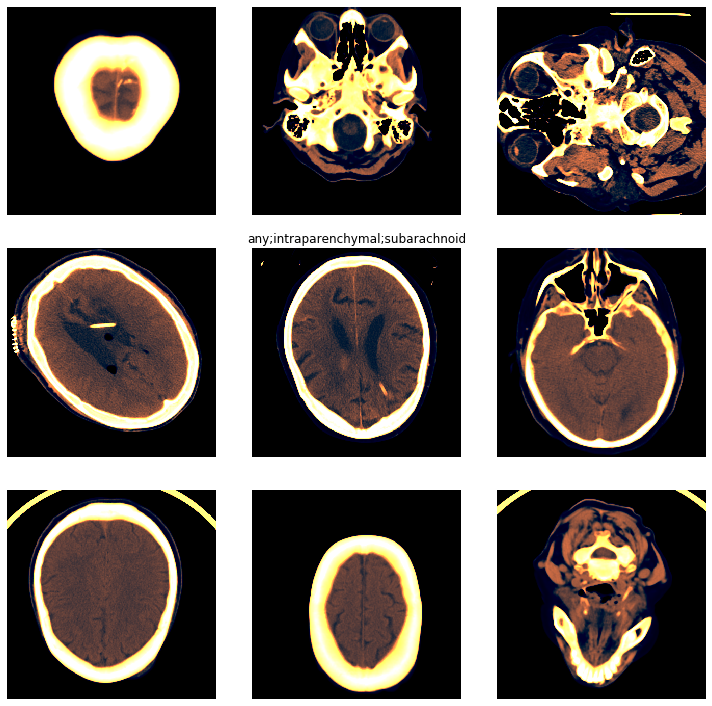

In [16]:
im_list = ImageList.from_df(train_df, path=config['PATH_DATA']+"stage_1_train_images")
data = (im_list.split_from_df()
               .label_from_df(label_delim=" ")
               .databunch(bs=config['BATCH_SIZE'], num_workers=config['NUM_WORKERS_ON_MACHINE'])
               .normalize(imagenet_stats))

data.show_batch(3, figsize=(10,10))

## Model

In [18]:
def get_pretrained_model(model_name='resnet18', num_classes=1000, num_channels=3,
                         pretrained=True, use_bn=False):
    if pretrained:
        preloaded = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
    else:
        preloaded = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained=None)
    #print(preloaded)
    
    if use_bn:
        preloaded = nn.Sequential(OrderedDict([
                        ('norm0', nn.BatchNorm2d(6)),
                        ('model', preloaded)]))
        model = preloaded.model
    else:
        model = preloaded
    
    if num_channels != 3:
        trained_kernel = model.conv1.weight
        new_conv = nn.Sequential(nn.Conv2d(num_channels, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False))
        with torch.no_grad():
            new_conv[0].weight[:,:] = torch.stack([torch.mean(trained_kernel, 1)]*num_channels, dim=1)
        model.conv1 = new_conv
    
    fc_input_features = model.last_linear.in_features*49
    model.last_linear = nn.Linear(fc_input_features, num_classes, bias=True)
    
    return preloaded

In [19]:
model = get_pretrained_model(model_name='resnext101_32x4d',
                             num_classes=config['CLASSES'],
                             num_channels=config['CHANNELS'],
                             use_bn=config['USE_BN'])
model.to(config['DEVICE']);

## Learner

In [20]:
data.classes

['any',
 'epidural',
 'intraparenchymal',
 'intraventricular',
 'subarachnoid',
 'subdural']

In [21]:
#!git clone https://github.com/fastai/fastai_dev.git
from fastai_dev.fastai2.basics import BaseLoss

In [22]:
# because target='any' is the 1th column in y_true
labels_weight = torch.tensor([2.0, 1.0, 1.0, 1.0, 1.0, 1.0]).to(config['DEVICE'])
loss = BaseLoss(nn.BCEWithLogitsLoss,
                pos_weight=labels_weight, floatify=True, flatten=False,
                is_2d=False, activation=torch.sigmoid)

learn = Learner(data=data,
                model=model,
                loss_func=loss,
                opt_func=partial(RAdam, weight_decay=1e-4),
                callback_fns=ShowGraph).to_fp16()
# learn.model = nn.DataParallel(learn.model)
learn.path = Path(config['MODEL_NAME'])
checkpoint_callback = SaveModelCallback(learn, name=config['MODEL_NAME'],
                                        every='epoch', monitor='valid_loss')

---

epoch,train_loss,valid_loss,time
0,0.107307,0.100765,2:10:19
1,0.102444,0.094314,2:10:47
2,0.091255,0.088862,2:08:50
3,0.083055,0.085693,2:04:55
4,0.078024,0.084199,2:05:16
5,0.076801,0.080609,2:06:29
6,0.068491,0.079008,2:09:31


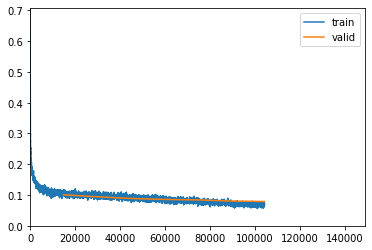

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(
    10,
    config['LR'],
    callbacks=[checkpoint_callback],
)

Loaded ResNext101_32x4d-RAdam-fp16_6


epoch,train_loss,valid_loss,time
7,0.063669,0.081009,2:08:08
8,0.056189,0.084147,2:06:31


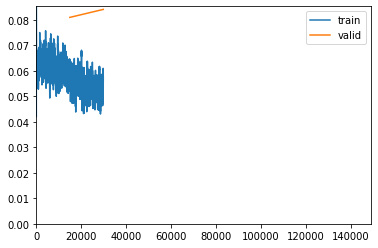

KeyboardInterrupt: 

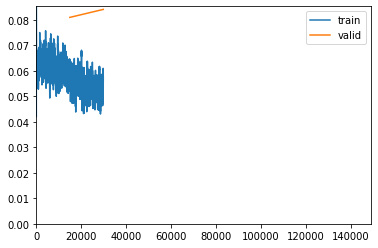

In [23]:
best_epoch = 6
learn.load('{0}{1}/models/{1}_{2}'.format(config['PATH_WEIGHTS'], config['MODEL_NAME'], best_epoch))

learn.unfreeze()
learn.fit_one_cycle(
    10,
    max_lr=config['LR'],
    callbacks=[checkpoint_callback],
    start_epoch=best_epoch+1,
)

## PAY ATTENTION! DANGEROUS!
## BICYCLE D4 TTA CODE BELOW! :)

In [24]:
from albumentations import DualTransform

class Rotate90(DualTransform):
    def apply(self, img, factor=1, **params):
        """
        Args:
            factor (int): number of times the input will be rotated by 90 degrees.
        """
        return np.ascontiguousarray(np.rot90(img, factor))

    def get_transform_init_args_names(self):
        return ()
    
class Rotate180(DualTransform):
    def apply(self, img, factor=2, **params):
        """
        Args:
            factor (int): number of times the input will be rotated by 90 degrees.
        """
        return np.ascontiguousarray(np.rot90(img, factor))

    def get_transform_init_args_names(self):
        return ()
    
class Rotate270(DualTransform):
    def apply(self, img, factor=3, **params):
        """
        Args:
            factor (int): number of times the input will be rotated by 90 degrees.
        """
        return np.ascontiguousarray(np.rot90(img, factor))

    def get_transform_init_args_names(self):
        return ()

In [25]:
def change_open_image_function(tta_index):
    resize_transform = Resize(config['IMG_SIZE'], config['IMG_SIZE'], p=1.0)
    
    def new_open_image(path, div=True, convert_mode=None, after_open=None):
        dcm = pydicom.dcmread(str(path))
        if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
            correct_dcm(dcm)
        intercept, slope = get_windowing(dcm)
        pixel_array = dcm.pixel_array.astype(np.int16) # "uint8"
        im_1 = window_image(pixel_array, 40, 80, intercept, slope) # brain
        im_2 = window_image(pixel_array, 80, 200, intercept, slope) # subdural
        im_3 = window_image(pixel_array, 300, 1000, intercept, slope) # bone
        im = np.stack((im_1, im_2, im_3), axis=-1)
        
        if tta_index == 0:
            tta_transforms = Compose([resize_transform])
        elif tta_index == 1:
            tta_transforms = Compose([resize_transform, HorizontalFlip(p=1.0)])
        elif tta_index == 2:
            tta_transforms = Compose([resize_transform, VerticalFlip(p=1.0)])
        elif tta_index == 3:
            tta_transforms = Compose([resize_transform, Rotate90(p=1.0)])
        elif tta_index == 4:
            tta_transforms = Compose([resize_transform, Rotate180(p=1.0)])
        elif tta_index == 5:
            tta_transforms = Compose([resize_transform, Rotate270(p=1.0)])
        
        transformed_im = tta_transforms(image=im)['image']
        x = pil2tensor(transformed_im, dtype=np.float32)
        return Image(x)
    
    vision.data.open_image = new_open_image

---

In [27]:
best_epoch = 6
learn.load('{0}{1}/models/{1}_{2}'.format(config['PATH_WEIGHTS'], config['MODEL_NAME'], best_epoch))
submission = pd.read_csv(config['PATH_DATA']+"stage_1_sample_submission.csv")
test_fnames = submission["ID"].str.split("_", n=2, expand=True)[1].unique()
test_fnames = pd.DataFrame("ID_" + test_fnames + ".dcm")
test_im_list = ImageList.from_df(test_fnames, path=config['PATH_DATA']+"stage_1_test_images")
learn.data.add_test(test_im_list)

In [28]:
tta_preds = np.zeros((len(test_im_list), config['CLASSES']))
TTA = 6
for i in range(TTA):
    change_open_image_function(i)
    preds = learn.get_preds(ds_type=DatasetType.Test)
    preds = preds[0].numpy()
    tta_preds += preds / TTA
    print(preds.shape)
    print('TTA #{} completed'.format(i))

(78545, 6)
TTA #5 completed


In [30]:
np.save('predictions/{0}_{1}_lr{2}_TTA_D4.npy'.format(config['MODEL_NAME'], best_epoch, config['LR_STR']),
        tta_preds)

In [29]:
print('EPOCH #{} TTA D4'.format(best_epoch))
submission.Label = np.roll(tta_preds, -1, axis=1).reshape(-1)
submission.to_csv("submits/{0}_{1}_lr{2}_TTA_D4.csv".format(config['MODEL_NAME'], best_epoch, config['LR_STR']), index=False)
# submission['Label'].hist(bins=100, figsize=[12,6], xrot=90)
submission['htype'] = submission["ID"].str.split("_", n=2, expand=True)[2]
submission.groupby('htype').mean().head(6)

EPOCH #6 TTA D4


,Label
htype,
any,0.123771
epidural,0.013074
intraparenchymal,0.037582
intraventricular,0.026888
subarachnoid,0.041118
subdural,0.037877
